In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'  'Shared drives'


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
os.chdir('/gdrive/My Drive')

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("CC2020_train_final.csv")

In [ ]:
grp_df = pd.read_csv("grouped_data.csv")
grp_df.drop(labels=grp_df.columns[0], axis=1, inplace=True)
grp_df.head()

,INBRED,TESTER,mean
0,Inbred_1071,Tester_1345,0.986544
1,Inbred_1071,Tester_4373,1.057704
2,Inbred_1071,Tester_4473,1.023704
3,Inbred_1071,Tester_4541,1.014735
4,Inbred_1071,Tester_5305,1.062727


In [ ]:
mat = grp_df.pivot(index='INBRED', columns='TESTER', values='mean').values

In [ ]:
train_df = grp_df.pivot(index='INBRED', columns='TESTER', values='mean')

In [ ]:
type(mat)

numpy.ndarray

In [ ]:
nonzero = []
for i in range(mat.shape[1]):
    nonzero.append(sum(~np.isnan(mat[:,i]))) 

In [ ]:
import matplotlib.pyplot as plt

(array([290., 117.,  40.,  23.,  11.,   4.,   3.,   3.,   2.,   3.]),
 array([  1. ,  16.6,  32.2,  47.8,  63.4,  79. ,  94.6, 110.2, 125.8,
        141.4, 157. ]),
 <a list of 10 Patch objects>)

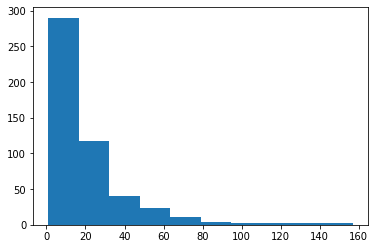

In [ ]:
plt.hist(nonzero)

In [ ]:
dict_ = {k: (~train_df[k].isnull()).sum() for k in train_df.columns}
sorted_d = sorted(dict_.items(), key=lambda x: x[1])

In [ ]:
test_df = train_df.copy()
test_df = test_df * 0

In [ ]:
# creating test data
np.random.seed(5)
min_sel = 1
picked = set()
for col , num in sorted_d:
    if num > min_sel:
        full_col = train_df[col]
        indices = train_df[~full_col.isnull()].index
#         print(indices)
        indices = [ind for ind in indices if ind not in picked]
        if len(indices) > 0:
            pick = np.random.choice(indices, size = max(1, len(indices)//10))
            for i in indices:
                picked.add(i)
            for p in pick:
                test_df.loc[p, col] = train_df.loc[p, col]
                train_df.loc[p, col] = 0
    

In [ ]:
train_df.fillna(0.0, inplace=True)
test_df.fillna(0.0, inplace=True)

In [ ]:
class MF():
    
    def __init__(self, R, K, alpha, beta, iterations, lambda_bias, test=None):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.
        
        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """
        
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.lambda_bias = lambda_bias
        self.iterations = iterations
        self.test = test

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        # Perform stochastic gradient descent for number of iterations
        training_process = []
        test_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
#                 print("Iteration: %d ; error = %.4f" % (i+1, mse))
                temp_pred = self.full_matrix()
                test_process.append(get_mse(temp_pred, self.test))
        
        return training_process, test_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        error /= len(xs)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)
            
            # Update biases
            self.b_u[i] += self.alpha * (e - self.lambda_bias * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.lambda_bias * self.b_i[j])
            
            # Create copy of row of P since we need to update it but use older values for update on Q
            P_i = self.P[i, :][:]
            
            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * P_i - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)  + mf.b



In [ ]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [ ]:
kmax = 30
ks  = range(2, kmax+1, 2)
alphas = [10**i for i in range(-5,0)]
betas = [10**i for i in range(-5,0)]
lambdas = [10**i for i in range(-5,0)]
best_test_error = {}
for k in ks:
    print(f'running k = {k}')
    if k > 5:
        for a in alphas:
            for beta in betas:
                for lambda_bias in lambdas:
                    
                    mf = MF(train_df.values, K=k, alpha=a, beta=beta, iterations=300, lambda_bias=lambda_bias, test=test_df.values)
                    training_process, test_process = mf.train()
                    best_test_error[(k, a, beta, lambda_bias)] = min(test_process)

running k = 2
running k = 4
running k = 6
running k = 8
running k = 10
running k = 12
running k = 14
running k = 16
running k = 18
running k = 20
running k = 22
running k = 24
running k = 26
running k = 28
running k = 30


In [ ]:
line

'(26, 0.001, 0.001, 1e-05), 0.0027260186574101183\n'

In [ ]:
line[1:].split(',')

['26', ' 0.001', ' 0.001', ' 1e-05)', ' 0.0027260186574101183\n']

In [ ]:
def _split(line):
    '''split a line and return the parameters we are interested in '''
    #line = line.trim()
    k, a, beta, lambda_bias, _ = [float(item) if i < 3 else item[:-1] \
                                  for i, item in enumerate(line[1:].split(','))]
    return int(k), a, beta, float(lambda_bias)

file_name = 'results.txt'
file = open(file_name, 'r')
to_write = open('split3_k35.txt', 'a')
for line in file:
    best_test_error = {}
    k, a, beta, lambda_bias = _split(line)
    mf = MF(train_df.values, K=30, alpha=a, beta=beta, iterations=100, lambda_bias=lambda_bias, test=test_df.values)
    training_process, test_process = mf.train()
    best_test_error[(k, a, beta, lambda_bias)] = min(test_process)
    # save in a file
    break
    to_write.write(str(best_test_error.items()))
    to_write.write("\n")
    print(min(test_process))
to_write.close()
file.close()

In [ ]:
mf = MF(train_df.values, 26, 0.001, 0.001, 300, 1e-05, test=test_df.values)
training_process, test_process = mf.train()

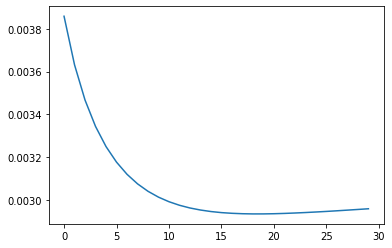

In [ ]:
plt.plot(test_process)

In [ ]:
test_process

[0.0028962249137515586,
 0.002819793608426278,
 0.0028426597225839983,
 0.002872832151831528,
 0.002901468305066955,
 0.0029279647507372097,
 0.0029474346744742196,
 0.0029661750981782855,
 0.002981160570220183,
 0.002994108605067302,
 0.0030084893494675344,
 0.0030148946129061717,
 0.003027225691010987,
 0.0030347061271523436,
 0.00304477980475793,
 0.003049547340743213,
 0.0030585111209421923,
 0.003060750360544173,
 0.0030685414260405524,
 0.0030723990482643846,
 0.003076777835988558,
 0.0030773964528941307,
 0.0030792075680774753,
 0.003080556316395245,
 0.003082238175067082,
 0.003083016357754063,
 0.0030863282419726877,
 0.0030834622012222567,
 0.003084214661589409,
 0.0030848699057036584]

In [ ]:
to_write = open('split1.txt', 'a')
to_write.write("a\\n")
to_write.close()

In [ ]:
# mf = MF(train_df.values, K=10, alpha=0.01, beta=0.1, iterations=300, lambda_bias=0.15, test=test_df.values)
# training_process, test_process = mf.train()

(array([3.4000e+01, 6.5600e+02, 6.4410e+03, 4.0144e+04, 1.2346e+05,
        1.0554e+05, 1.6641e+04, 8.0100e+02, 3.2500e+02, 8.6000e+01]),
 array([0.77677574, 0.82165444, 0.86653314, 0.91141183, 0.95629053,
        1.00116923, 1.04604792, 1.09092662, 1.13580532, 1.18068401,
        1.22556271]),
 <a list of 10 Patch objects>)

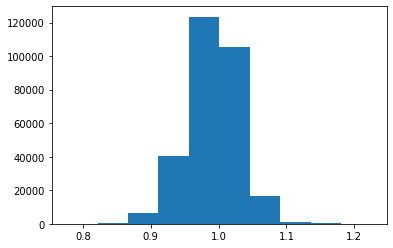

In [ ]:
plt.hist(mf.full_matrix().flatten())

In [ ]:
best_test_error

{(6, 1e-05, 1e-05, 1e-05): 0.008885469738702868,
 (6, 1e-05, 1e-05, 0.0001): 0.00809057798037285,
 (6, 1e-05, 1e-05, 0.001): 0.008526277998448458,
 (6, 1e-05, 1e-05, 0.01): 0.007658705409749787,
 (6, 1e-05, 1e-05, 0.1): 0.009303150580905575,
 (6, 1e-05, 0.0001, 1e-05): 0.010049781924492629,
 (6, 1e-05, 0.0001, 0.0001): 0.008571120286831628,
 (6, 1e-05, 0.0001, 0.001): 0.008707305845104903,
 (6, 1e-05, 0.0001, 0.01): 0.010177979352572957,
 (6, 1e-05, 0.0001, 0.1): 0.008094645701388488,
 (6, 1e-05, 0.001, 1e-05): 0.009102519424874557,
 (6, 1e-05, 0.001, 0.0001): 0.009670380716355237,
 (6, 1e-05, 0.001, 0.001): 0.009554407121516664,
 (6, 1e-05, 0.001, 0.01): 0.007798748012888805,
 (6, 1e-05, 0.001, 0.1): 0.009402858126614401,
 (6, 1e-05, 0.01, 1e-05): 0.007970454612244883,
 (6, 1e-05, 0.01, 0.0001): 0.00784530006258138,
 (6, 1e-05, 0.01, 0.001): 0.007807517594564667,
 (6, 1e-05, 0.01, 0.01): 0.007166734404658494,
 (6, 1e-05, 0.01, 0.1): 0.009035078511882769,
 (6, 1e-05, 0.1, 1e-05): 0.007

In [ ]:
ordered_results = sorted(best_test_error.items(), key=lambda x: x[1])

In [ ]:
ordered_results

[((26, 0.001, 0.001, 1e-05), 0.0027260186574101183),
 ((24, 0.01, 1e-05, 0.001), 0.0027370889092149567),
 ((22, 0.001, 0.01, 1e-05), 0.002755398439789228),
 ((26, 0.01, 1e-05, 0.001), 0.0027588146940080477),
 ((20, 0.001, 0.001, 0.01), 0.002762529417228305),
 ((30, 0.01, 0.0001, 0.01), 0.002763191240602552),
 ((28, 0.001, 0.01, 0.001), 0.002763730001994065),
 ((22, 0.01, 0.0001, 0.01), 0.002767020310235907),
 ((26, 0.01, 0.0001, 0.1), 0.002767206118311563),
 ((20, 0.01, 0.1, 1e-05), 0.0027684106036501765),
 ((26, 0.001, 1e-05, 0.0001), 0.0027684583927108054),
 ((30, 0.001, 0.001, 1e-05), 0.002770945154257955),
 ((22, 0.001, 0.1, 0.0001), 0.0027710220514274336),
 ((18, 0.001, 0.001, 0.0001), 0.0027744762316897847),
 ((30, 0.001, 0.001, 0.1), 0.0027745860228178066),
 ((24, 0.01, 0.01, 0.1), 0.0027755648873125922),
 ((26, 0.001, 1e-05, 1e-05), 0.002776347425961026),
 ((26, 0.001, 0.1, 0.1), 0.002778446183093667),
 ((24, 0.01, 0.001, 0.1), 0.0027834372251950763),
 ((20, 0.01, 0.001, 1e-05)

In [ ]:
best_test_error.itertuple()

AttributeError: 'dict' object has no attribute 'itertuple'

In [ ]:
max(best_test_error.values())

0.010177979352572957

In [ ]:
# elements = [val for i, val in enumerate(ordered_results) if i < 20]
count = 0
with open('results.txt', 'w') as f:
    while count < 20:
        val = ordered_results[count]
        f.write(str(val)[1:-1] + '\n')
        count +=1


In [ ]:
k, a, beta, lambda_bias = 26, 0.001, 0.001, 1e-05
mf = MF(train_df.values, K=k, alpha=a, beta=beta, iterations=300, lambda_bias=lambda_bias, test=test_df.values)
training_process, test_process = mf.train()
plt.plot(test_process)

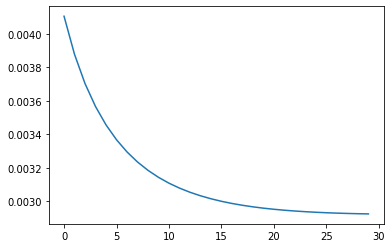

In [ ]:
plt.plot(test_process)

In [ ]:
print(min(test_process))

0.0029242517667150227


In [ ]:
# another MF method

In [ ]:
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.1, 
                 user_fact_reg=0.1,
                 item_bias_reg=0.1,
                 user_bias_reg=0.1,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.01):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        self.user_vecs_velocity = np.zeros((self.n_users, self.n_factors))
        self.item_vecs_velocity = np.zeros((self.n_items, self.n_factors))

        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.momentum = 0.9
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.user_bias_velocity = np.zeros(self.n_users)
            self.item_bias_velocity = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias_velocity[u] = self.momentum * self.user_bias_velocity[u] + \
                                        self.learning_rate * (e - self.user_bias_reg * self.user_bias[u])
            self.user_bias[u] += self.user_bias_velocity[u]

            self.item_bias_velocity[i] = self.momentum * self.item_bias_velocity[i] + \
                                        self.learning_rate * (e - self.item_bias_reg * self.item_bias[i])
            self.item_bias[i] += self.item_bias_velocity[i]

            # self.user_bias[u] += self.learning_rate * \
            #                     (e - self.user_bias_reg * self.user_bias[u])
            # self.item_bias[i] += self.learning_rate * \
            #                     (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs_velocity[u, :] = self.momentum * self.user_vecs_velocity[u, :] + \
                                        self.learning_rate * \
                                        (e * self.item_vecs[i, :] - \
                                        self.user_fact_reg * self.user_vecs[u,:])
            self.user_vecs[u, :] += self.user_vecs_velocity[u, :]

            self.item_vecs_velocity[i, :] = self.momentum * self.item_vecs_velocity[i, :] + \
                                        self.learning_rate * \
                                        (e * self.user_vecs[u, :] - \
                                        self.item_fact_reg * self.item_vecs[i,:])
            self.item_vecs[i :] += self.item_vecs_velocity[i, :]

            # self.user_vecs[u, :] += self.learning_rate * \
            #                         (e * self.item_vecs[i, :] - \
            #                          self.user_fact_reg * self.user_vecs[u,:])
            # self.item_vecs[i, :] += self.learning_rate * \
            #                         (e * self.user_vecs[u, :] - \
            #                          self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.01):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

In [ ]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [ ]:
#MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
MF_SGD = ExplicitMF(train_df.values,
                    n_factors=40,
                    learning='sgd',
                    
                    item_fact_reg=0.1, 
                    user_fact_reg=0.1,
                    item_bias_reg=0.1,
                    user_bias_reg=0.1,
                    verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200,300]
MF_SGD.calculate_learning_curve(iter_array, test_df.values, learning_rate=0.001)

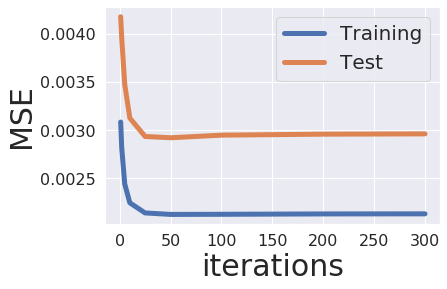

In [ ]:
plot_learning_curve(iter_array, MF_SGD)

In [ ]:
iter_array

[1, 2, 5, 10, 25, 50, 100, 200]

In [ ]:
get_mse(MF_SGD.predict_all(),test_df.values)

0.0029622236201189514

In [ ]:
get_mse(mf.full_matrix(),test_df.values)

0.9229565643517352

In [ ]:
# try to take log, train, then exponentiate back
train_df_log = np.ma.log(train_df.values)
train_df_log = train_df_log.filled(0)
test_df_log = np.ma.log(test_df.values)
test_df_log = test_df_log.filled(0)

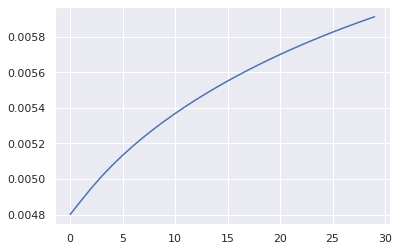

In [ ]:
k, a, beta, lambda_bias = 26, 0.001, 0.001, 1e-05
mf = MF(train_df_log, K=k, alpha=a, beta=beta, iterations=300, lambda_bias=lambda_bias, test=test_df_log)
training_process, test_process = mf.train()
plt.plot(test_process)

In [ ]:
get_mse(np.exp(mf.full_matrix()),test_df.values)

0.005394185873743974

In [ ]:
MF_SGD = ExplicitMF(train_df.values,
                    n_factors=40,
                    learning='sgd',
                    item_fact_reg=0.1, 
                    user_fact_reg=0.1,
                    item_bias_reg=0.1,
                    user_bias_reg=0.1,
                    verbose=False)
iter_array = [1, 2, 5, 10, 25, 50]
MF_SGD.calculate_learning_curve(iter_array, test_df.values, learning_rate=0.001)

TypeError: ignored

In [ ]:
MF_SGD = ExplicitMF(train,
                    n_factors=40,
                    learning='sgd',
                    item_fact_reg=0.1, 
                    user_fact_reg=0.1,
                    item_bias_reg=0.1,
                    user_bias_reg=0.1,
                    verbose=True)
iter_array = [1, 2, 5, 10, 25, 50]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

TypeError: ignored

In [ ]:
get_mse(np.exp(MF_SGD.predict_all()),np.exp(test))

0.0015713252613188792

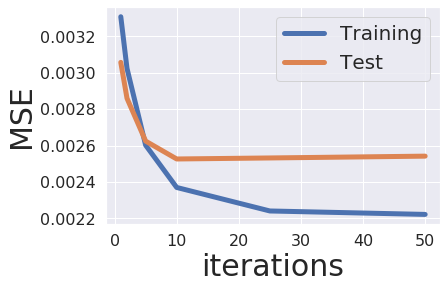

In [ ]:
plot_learning_curve(iter_array, MF_SGD)

In [ ]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [ ]:
X_incomplete = train_df.replace(0,np.nan)

In [ ]:
X_incomplete_log = np.log(X_incomplete)

In [ ]:
X_filled_nnm = NuclearNormMinimization().fit_transform(X_incomplete.values)

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 2085515
eps = 1.00e-04, alpha = 1.50, max_iters = 50000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 1181761, constraints m = 1770017
Cones:	primal zero / dual free vars: 294128
	linear vars: 882384
	sd vars: 593505, sd blks: 1
Setup time: 2.81e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.41e+22  1.47e+22  1.00e+00 -2.34e+25  5.72e+24  7.53e+24  2.36e+00 
Failure:Interrupted


SolverError: ignored

In [ ]:
null_mat = X_incomplete_log.isnull().values

In [ ]:
null_mat[0,:].sum()

483

In [ ]:
null_mat.shape

(593, 496)

In [ ]:
X_incomplete = train_df.copy()

In [ ]:
for i in range(len(null_mat)):
    #print(train_df_log[i,0])
    if null_mat[i,:].sum() == 496:
        print("zero row")
        idx = np.random.choice(495)
        X_incomplete.iloc[i,idx] = 0.01

zero row
zero row
zero row


In [ ]:
X_incomplete.replace(0, np.nan, inplace= True)

In [ ]:
X_incomplete_log

TESTER,Tester_1345,Tester_1349,Tester_1397,Tester_2636,Tester_2652,Tester_2683,Tester_2689,Tester_2690,Tester_2721,Tester_2724,Tester_2736,Tester_2747,Tester_2773,Tester_3404,Tester_3440,Tester_3484,Tester_3485,Tester_3504,Tester_3507,Tester_3521,Tester_3565,Tester_3567,Tester_3573,Tester_3577,Tester_3582,Tester_3791,Tester_3796,Tester_4025,Tester_4048,Tester_4051,Tester_4059,Tester_4062,Tester_4063,Tester_4065,Tester_4067,Tester_4072,Tester_4082,Tester_4083,Tester_4097,Tester_4099,...,Tester_8038,Tester_8042,Tester_8043,Tester_8044,Tester_8046,Tester_8047,Tester_8050,Tester_8051,Tester_8052,Tester_8053,Tester_8055,Tester_8057,Tester_8059,Tester_8060,Tester_8063,Tester_8064,Tester_8070,Tester_8075,Tester_8078,Tester_8080,Tester_8084,Tester_813,Tester_8159,Tester_819,Tester_8198,Tester_8199,Tester_8202,Tester_8204,Tester_8205,Tester_8208,Tester_821,Tester_8218,Tester_8246,Tester_8248,Tester_8249,Tester_8250,Tester_8253,Tester_8254,Tester_828,Tester_829
INBRED,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Inbred_1071,-0.013548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inbred_122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.081206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inbred_1337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.10074,-0.096541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inbred_1339,NaN,NaN,NaN,NaN,-0.158006,NaN,NaN,NaN,NaN,NaN,NaN,-0.080846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inbred_1340,NaN,0.013377,NaN,NaN,NaN,NaN,0.004255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.059522,NaN,-0.099041,NaN,-0.100363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.042626,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Inbred_818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inbred_819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inbred_821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024457,NaN,NaN,NaN,NaN,NaN,-0.016101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.015933,-0.018225,NaN,NaN,

In [ ]:
si = SoftImpute(max_iters = 1000)


In [ ]:
# X_incomplete_normalized = BiScaler().fit_transform(train_na)
X_filled_softimpute = si.fit_transform(train_na)

In [ ]:
get_mse(np.exp(X_filled_softimpute), np.exp(test))

0.0002389444608362629

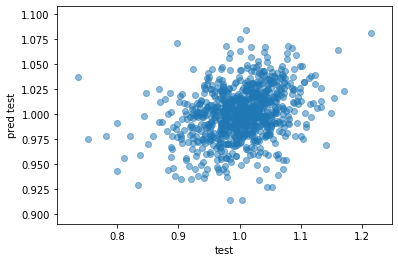

In [ ]:
plt.scatter(np.exp(test[test.nonzero()]).flatten(), np.exp(X_filled_softimpute[test.nonzero()].flatten()), alpha = 0.5)
#plt.plot(np.exp(test[test.nonzero()]).flatten(), alpha = 0.5)
plt.xlabel("test")
plt.ylabel("pred test")
plt.show()

In [ ]:
np.sqrt(0.00017838840904557725)

0.013356212376477744

In [ ]:
np.exp(train).max()

1.2400148732500003

In [ ]:
np.exp(X_filled_softimpute).min()

0.6502730801666666

In [ ]:
np.exp(X_filled_softimpute).max()

1.2400148732500003

In [ ]:
get_mse(MF_SGD.predict_all(),test_df.values)

0.002958621269561941

In [ ]:
get_mse(np.exp(MF_SGD.predict_all()),test_df.values)

0.002907758392533215

In [ ]:
res = np.exp(MF_SGD.predict_all())

In [ ]:
res.min()

0.7541088983952152

In [ ]:
res.max()

1.169347899343899

In [ ]:
train_df.values.max()

1.24001487325

In [ ]:
res.nonzero()

(array([  0,   0,   0, ..., 592, 592, 592]),
 array([  0,   1,   2, ..., 493, 494, 495]))

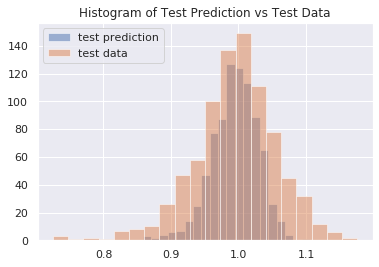

In [ ]:
np.exp(MF_SGD.predict_all())
plt.hist(np.exp(MF_SGD.predict_all())[test.nonzero()].flatten(), alpha = 0.5, label = "test prediction",bins = 20)
plt.title("Histogram of Test Prediction vs Test Data")
plt.hist(np.exp(test)[test.nonzero()].flatten(), alpha = 0.5, label = "test data",bins = 20)
plt.legend(loc = "best")
plt.show()

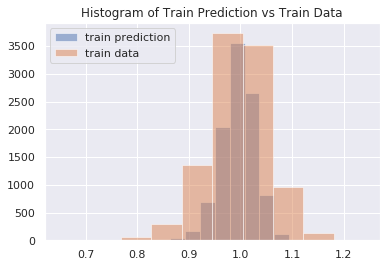

In [ ]:
plt.hist(np.exp(MF_SGD.predict_all())[train.nonzero()].flatten(), alpha = 0.5, label = "train prediction")
plt.title("Histogram of Train Prediction vs Train Data")
plt.hist(np.exp(train)[train.nonzero()].flatten(), alpha = 0.5, label = "train data")
plt.legend(loc = "best")
plt.show()

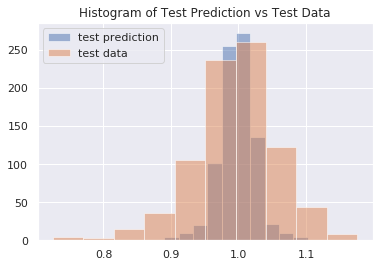

In [ ]:
plt.hist(np.exp(X_filled_softimpute)[test.nonzero()].flatten(), alpha = 0.5, label = "test prediction")
plt.title("Histogram of Test Prediction vs Test Data")
plt.hist(np.exp(test)[test.nonzero()].flatten(), alpha = 0.5, label = "test data")
plt.legend(loc = "best")
plt.show()

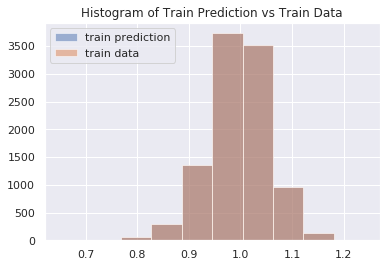

In [ ]:
plt.hist(np.exp(X_filled_softimpute)[train.nonzero()].flatten(), alpha = 0.5, label = "train prediction")
plt.title("Histogram of Train Prediction vs Train Data")
plt.hist(np.exp(train)[train.nonzero()].flatten(), alpha = 0.5, label = "train data")
plt.legend(loc = "best")
plt.show()

In [ ]:
np.exp(X_filled_softimpute)[test.nonzero()].flatten().min()

0.9037870733770542

In [ ]:
np.exp(test)[test.nonzero()].flatten().min()

0.725141606

In [ ]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
np.all(train*test) == 0

True

(array([  2.,   2.,  15.,  37., 129., 298., 238.,  78.,  30.,   6.]),
 array([0.9049697 , 0.9213087 , 0.9376477 , 0.95398671, 0.97032571,
        0.98666471, 1.00300371, 1.01934272, 1.03568172, 1.05202072,
        1.06835973]),
 <a list of 10 Patch objects>)

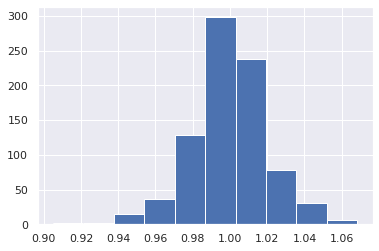

In [ ]:
plt.hist(np.exp(X_filled_softimpute)[test.nonzero()].flatten())

(array([ 1.,  2.,  3., 16., 17., 40., 55., 58., 28., 14.]),
 array([0.73414242, 0.77209419, 0.81004596, 0.84799773, 0.8859495 ,
        0.92390128, 0.96185305, 0.99980482, 1.03775659, 1.07570836,
        1.11366013]),
 <a list of 10 Patch objects>)

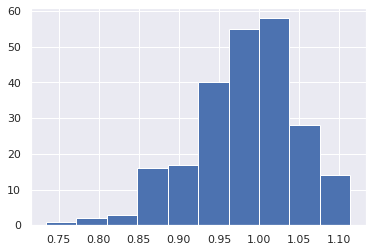

In [ ]:
plt.hist(test_df.values[test_df.values.nonzero()].flatten())

(array([  12.,   39.,  125.,  714., 2224., 3899., 2810.,  763.,   89.,
          10.]),
 array([0.83456988, 0.8635518 , 0.89253372, 0.92151563, 0.95049755,
        0.97947947, 1.00846139, 1.03744331, 1.06642522, 1.09540714,
        1.12438906]),
 <a list of 10 Patch objects>)

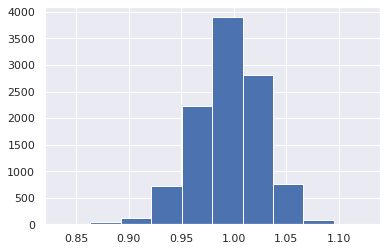

In [ ]:
plt.hist(res[train_df.values.nonzero()].flatten())

(array([   4.,   17.,   59.,  304., 1430., 3945., 3748., 1024.,  141.,
          13.]),
 array([0.65027308, 0.70924726, 0.76822144, 0.82719562, 0.8861698 ,
        0.94514398, 1.00411816, 1.06309234, 1.12206651, 1.18104069,
        1.24001487]),
 <a list of 10 Patch objects>)

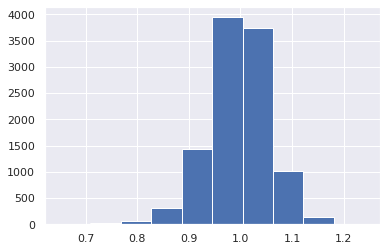

In [ ]:
plt.hist(train_df.values[train_df.values.nonzero()].flatten())

In [ ]:
train_df.values.nonzero()[0]

array([  0,   0,   0, ..., 592, 592, 592])

In [ ]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200,250]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None


for rate in learning_rates:
    print ('Rate: {}'.format(rate))
    MF_SGD = ExplicitMF(train_df_log, n_factors=35, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test_df_log, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print ('New optimal hyperparameters')
        print (pd.Series(best_params))

Rate: 1e-05
New optimal hyperparameters
learning_rate                                             1e-05
n_iter                                                      250
train_mse                                            0.00344385
test_mse                                             0.00463857
model            <__main__.ExplicitMF object at 0x7f80681b1438>
dtype: object
Rate: 0.0001
New optimal hyperparameters
learning_rate                                            0.0001
n_iter                                                      250
train_mse                                            0.00279288
test_mse                                             0.00404349
model            <__main__.ExplicitMF object at 0x7f806b72f6d8>
dtype: object
Rate: 0.001
New optimal hyperparameters
learning_rate                                             0.001
n_iter                                                      250
train_mse                                            0.00224101
test_mse           

In [ ]:
best_params #for learning rate

{'learning_rate': 0.01,
 'model': <__main__.ExplicitMF at 0x7f806b72f6d8>,
 'n_iter': 50,
 'test_mse': 0.0031775932985626527,
 'train_mse': 0.00222698179104251}

In [ ]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200, 250]
latent_factors = [ 5, 10, 20, 25, 30, 35, 40]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print ('Factors: {}'.format(fact))
    for reg in regularizations:
        print ('Regularization: {}'.format(reg))
        MF_SGD = ExplicitMF(train_df_log, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test_df_log, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print ('New optimal hyperparameters')
            print (pd.Series(best_params))

Factors: 5
Regularization: 0.001
New optimal hyperparameters
n_factors                                                 5
reg                                                   0.001
n_iter                                                  250
train_mse                                        0.00429246
test_mse                                          0.0101425
model        <__main__.ExplicitMF object at 0x7f8067d91c88>
dtype: object
Regularization: 0.01
New optimal hyperparameters
n_factors                                                 5
reg                                                    0.01
n_iter                                                  250
train_mse                                        0.00394383
test_mse                                         0.00921916
model        <__main__.ExplicitMF object at 0x7f8067d91d68>
dtype: object
Regularization: 0.1
New optimal hyperparameters
n_factors                                                 5
reg                               

In [ ]:
best_params #for factors and reg

{'model': <__main__.ExplicitMF at 0x7f8067d91eb8>,
 'n_factors': 40,
 'n_iter': 250,
 'reg': 0.01,
 'test_mse': 0.0031344368103530963,
 'train_mse': 0.002207891888466097}

In [ ]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [ ]:
MF_ALS = ExplicitMF(train_df_log, n_factors=30, \
                    user_reg=0.1, item_reg=0.1)

iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test_df_log)

In [ ]:
MF_ALS = ExplicitMF(train, n_factors=30, \
                    user_reg=0.1, item_reg=0.1)

iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

In [ ]:
#mse of ALS method 
als_pred = MF_ALS.predict_all()
als_pred = np.exp(als_pred)
print(als_pred.min())
print(als_pred.max())
print("mse of ALS method: ", get_mse(als_pred, test)) # it is better than SGD method :o 
print((np.exp(train)).max(), (np.exp(train)).min())
print((np.exp(test)).max(), (np.exp(test)).min())

0.679361917984153
1.2320636483990755
mse of ALS method:  1.0176985949065653
1.2400148732500003 0.6502730801666666
1.2043619012222222 0.7284031588571429


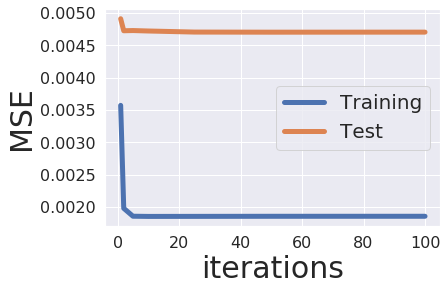

In [ ]:
plot_learning_curve(iter_array, MF_ALS)

In [ ]:
# my code to process the training data to have at least 1 entry in each row or column
train_df = pd.read_csv("CC2020_train_final.csv")
test_df = pd.read_csv("CC2020_test_final.csv")

In [ ]:
a = np.array([0,0,0])
a.nonzero()[0]
np.random.choice(a.nonzero()[0])

ValueError: ignored

In [ ]:
train_df = train_df[['INBRED', 'TESTER', 'YIELD']]
grouped_df = train_df.groupby(['INBRED','TESTER'], as_index=False).mean()
grouped_df['YIELD'] = np.log(grouped_df['YIELD']).values
train_df = grouped_df
def train_test_split(mat):
    test = np.zeros(mat.shape)
    train = mat.copy()
    for inbred in range(mat.shape[0]):
        test_yields = np.random.choice(mat[inbred, :].nonzero()[0], 
                                        size=max(1, len(mat[inbred, :].nonzero()[0])//10), 
                                        replace=False)
        train[inbred, test_yields] = 0.
        test[inbred, test_yields] = mat[inbred, test_yields]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test
inbred_index = {}
tester_index = {}
i = 0
j = 0
for idx, row in train_df.iterrows():
    if row['INBRED'] not in inbred_index:
        inbred_index[row['INBRED']] = i
        i += 1
    if row['TESTER'] not in tester_index:
        tester_index[row['TESTER']] = j
        j += 1
print(len(inbred_index))
print(len(tester_index))
print(i)
print(j)
n_inbred = 593
n_tester = 496
mat = np.zeros((n_inbred, n_tester))
for row in train_df.itertuples():
    mat[inbred_index[row[1]], tester_index[row[2]]] = row[3]
mat



593
496
593
496


array([[-0.01354771,  0.0561005 ,  0.02342727, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.02078493,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
def train_test_split(mat):
    test = np.zeros(mat.shape)
    train = mat.copy()
    for inbred in range(mat.shape[0]):
        if (mat[inbred, :].sum() == 0): print("row is zero")
        # print(mat[inbred, :].sum())
        test_yields = np.random.choice(mat[inbred, :].nonzero()[0], 
                                        size=max(0, len(mat[inbred, :].nonzero()[0])//10), 
                                        replace=False)
        train[inbred, test_yields] = 0.
        test[inbred, test_yields] = mat[inbred, test_yields]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [ ]:
train, test = train_test_split(mat)

In [ ]:
mat_na = np.zeros(mat.shape)
for i in range(len(mat)):
    for j in range(len(mat[0])):
        if mat[i,j] == 0:
            mat_na[i,j] = np.nan
        else:
            mat_na[i,j] = mat[i,j]

In [ ]:
mat_na

array([[-0.01354771,  0.0561005 ,  0.02342727, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,  0.02078493,         nan, ...,         nan,
                nan,         nan]])

In [ ]:
train_na = np.zeros(train.shape)
for i in range(len(train)):
    for j in range(len(train[0])):
        if train[i,j] == 0:
            train_na[i,j] = np.nan
        else:
            train_na[i,j] = train[i,j]

In [ ]:
mat.shape

(593, 496)

In [ ]:
np.isnan(train_na[0:])

array([[False, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True]])

In [ ]:
for i in range(train.shape[0]):
    if train[i,:].sum() == 0:
        print("row is zero")

In [ ]:
for i in range(mat.shape[0]):
    if mat[i,:].sum() == 0:
        print("row is zeros")

In [ ]:
#https://gist.github.com/kastnerkyle/9341182

# (C) Kyle Kastner, June 2014
# License: BSD 3 clause

import numpy as np
from scipy import sparse


def minibatch_indices(X, minibatch_size):
    X = list(X)
    minibatch_indices = np.arange(0, len(X), minibatch_size)
    minibatch_indices = np.asarray(list(minibatch_indices) + [len(X)])
    start_indices = minibatch_indices[:-1]
    end_indices = minibatch_indices[1:]
    return zip(start_indices, end_indices)


def shuffle_in_unison(a, b):
    """
    http://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    """
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)


def PMF(X, rank=10, learning_rate=0.001, momentum=0.8,
        regularization=0.25, minibatch_size=1000, max_epoch=1000,
        nan_value=0, status_percentage=0.1, random_state=None):
    """
    Python implementation of Probabilistic Matrix Factorization (PMF).
    Parameters
    ----------
    X: numpy array or scipy.sparse coo matrix, shape (n_users, n_items)
        Input data. If a dense array is passed in, it will be converted to a
        sparse matrix by looking for all `nan_value` numbers and treating them
        as empty.
    rank: int, optional (default=10)
       Rank of the low-rank factor matrices. A higher rank should result in a
       better approximation, at the cost of more memory and slower computataion.
    learning_rate: float, optional (default=0.001)
        Learning rate for minibatch gradient descent.
    momentum: float, optional (default=0.8)
        Momentum for minibatch gradient descent.
    regularization: float, optional (default=0.25)
        L2 regularization penalty for minibatch gradient descent.
    minibatch_size: int, optional (default=1000)
       The size of each minibatch. If this is larger than size of the dataset,
       will default to running over the whole dataset.
    max_epoch: int, optional (default=1000)
        The maximum number of epochs.
    nan_value: int, optional (default=0)
        This value will be masked out of the input for calculations
        Should match the value considered the "not rated" in the dataset X.
    status_percentage: float in (0, 1), optional (default=0.1)
        The relative percentage of `max_epochs` when status will be printed.
        For example, 0.1 is every 10%, 0.01 is every 1%, and so on. For
        the default values of max_epoch=1000, status_percentage=0.1 this
        is equivalent to a status print every 100 epochs.
    random_state: RandomState, int, or None, optional (default=None)
        Random state to pass in. Can be an int, None, or np.random.RandomState
        object.
    Returns
    -------
    U: array-like, shape (X.shape[0], rank)
        Row basis for reconstruction.
        Usage:
        reconstruction = np.dot(U, V.T) + X_mean
    V: array-like, shape (X.shape[1], rank)
        Column basis for reconstruction.
        Usage:
        reconstruction = np.dot(U, V.T) + X_mean
    X_mean: float
        Global mean prediction, needed for reconstruction
        Usage
        reconstruction = np.dot(U, V.T) + X_mean
    Notes
    -----
    Based on code from Ruslan Salakhutdinov
    http://www.cs.toronto.edu/~rsalakhu/code_BPMF/pmf.m
    Probabilistic Matrix Factorization, R. Salakhutdinov and A. Mnih,
    Advances in Neural Information Processing Systems 20, 2008
    """
    if not sparse.isspmatrix_coo(X):
        val_index = np.where(X != nan_value)
        X = sparse.coo_matrix((X[val_index[0], val_index[1]],
                               (val_index[0], val_index[1])))
    # Simplest prediction is the global mean
    X_mean = X.mean()
    lr = learning_rate
    reg = regularization
    mom = momentum
    if random_state is None or type(random_state) is int:
        random_state = np.random.RandomState(random_state)
    N, M = X.shape
    U = 0.1 * random_state.randn(N, rank)
    V = 0.1 * random_state.randn(M, rank)
    U_inc = np.zeros_like(U)
    V_inc = np.zeros_like(V)
    dU = np.zeros_like(U)
    dV = np.zeros_like(V)
    epoch = 0
    status_inc = int(np.ceil(max_epoch * status_percentage))
    print("Printing updates every %i epochs" % status_inc)
    status_points = list(range(0, max_epoch, status_inc)) + [max_epoch - 1]
    # Need this in order to index
    X_s = X.tolil()
    while epoch < max_epoch:
        # Get indices for non-NaN values
        r, c = X.nonzero()
        mb_indices = minibatch_indices(zip(r, c), minibatch_size)
        mb_indices = list(mb_indices)
        n_batches = len(mb_indices)
        shuffle_in_unison(r, c)
        mean_abs_err = 0.
        for i, j in mb_indices:
            # Reset derivative matrices each minibatch
            dU[:, :] = 0.
            dV[:, :] = 0.
            # Slice out row and column indices
            r_i = r[i:j]
            c_i = c[i:j]
            # Get data corresponding to the row and column indices
            X_i = X_s[r_i, c_i].toarray().ravel() - X_mean
            # Compute predictions
            pred = np.sum(U[r_i] * V[c_i], axis=1)
            # Compute how algorithm is doing
            mean_abs_err += np.sum(np.abs(pred - X_i)) / (n_batches * (j - i))
            # Loss has a tendency to be unstable, but is the "right thing"
            # to monitor instead of sum_abs_err
            # pred_loss = (pred - X_i) ** 2
            # Compute gradients
            grad_loss = 2 * (pred - X_i)
            grad_U = grad_loss[:, None] * V[c_i] + reg * U[r_i]
            grad_V = grad_loss[:, None] * U[r_i] + reg * V[c_i]
            dU[r_i] = grad_U
            dV[c_i] = grad_V
            # Momentum storage
            U_inc = mom * U_inc + lr * dU
            V_inc = mom * V_inc + lr * dV
            U -= U_inc
            V -= V_inc
        if epoch in status_points:
            print("Epoch %i of %i" % (epoch + 1, max_epoch))
            print("Mean absolute error %f" % (mean_abs_err))
        epoch += 1
    return U, V, X_mean



import matplotlib.pyplot as plt


Printing updates every 25 epochs
Epoch 1 of 250
Mean absolute error 1.641900
Epoch 26 of 250
Mean absolute error 0.675860
Epoch 51 of 250
Mean absolute error 0.158021
Epoch 76 of 250
Mean absolute error 0.123713
Epoch 101 of 250
Mean absolute error 0.128096
Epoch 126 of 250
Mean absolute error 0.120701
Epoch 151 of 250
Mean absolute error 0.135587
Epoch 176 of 250
Mean absolute error 0.135484
Epoch 201 of 250
Mean absolute error 0.123773
Epoch 226 of 250
Mean absolute error 0.116977
Epoch 250 of 250
Mean absolute error 0.115955


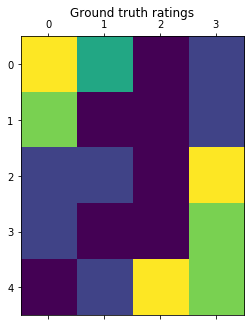

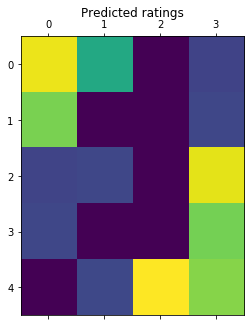

In [ ]:
R = np.array([[5, 3, 0, 1],
                [4, 0, 0, 1],
                [1, 1, 0, 5],
                [1, 0, 0, 4],
                [0, 1, 5, 4]], dtype=float)
U, V, m = PMF(R, learning_rate=0.001, momentum=0.95,\
                minibatch_size=2, rank=5, max_epoch=250, random_state=1999)
R2 = np.dot(U, V.T) + m
plt.matshow(R * (R > 0))
plt.title("Ground truth ratings")
plt.matshow(R2 * (R > 0))
plt.title("Predicted ratings")
plt.show()

In [ ]:
U, V, m = PMF(train, learning_rate=0.001, momentum=0.95,\
                minibatch_size=5, rank=30, max_epoch=250, random_state=1999)

Printing updates every 25 epochs
Epoch 1 of 250
Mean absolute error 0.058866
Epoch 26 of 250
Mean absolute error 0.044674
Epoch 51 of 250
Mean absolute error 0.044937
Epoch 76 of 250
Mean absolute error 0.045001
Epoch 101 of 250
Mean absolute error 0.045016
Epoch 126 of 250
Mean absolute error 0.045024
Epoch 151 of 250
Mean absolute error 0.045023
Epoch 176 of 250
Mean absolute error 0.045024
Epoch 201 of 250
Mean absolute error 0.045027
Epoch 226 of 250
Mean absolute error 0.045030
Epoch 250 of 250
Mean absolute error 0.045027


In [ ]:
pred = np.dot(U, V.T) + m

In [ ]:
get_mse(np.exp(pred), np.exp(test))

1.0154126011071843e-05

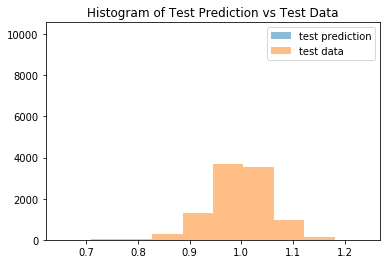

In [ ]:
plt.hist(np.exp(pred)[train.nonzero()].flatten(), alpha = 0.5, label = "test prediction")
plt.title("Histogram of Test Prediction vs Test Data")
plt.hist(np.exp(train)[train.nonzero()].flatten(), alpha = 0.5, label = "test data")
plt.legend(loc = "best")
plt.show()

(array([3.00000e+00, 4.00000e+00, 7.00000e+00, 2.94084e+05, 2.40000e+01,
        3.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0.99229637, 0.99427585, 0.99625532, 0.9982348 , 1.00021427,
        1.00219375, 1.00417323, 1.0061527 , 1.00813218, 1.01011166,
        1.01209113]),
 <a list of 10 Patch objects>)

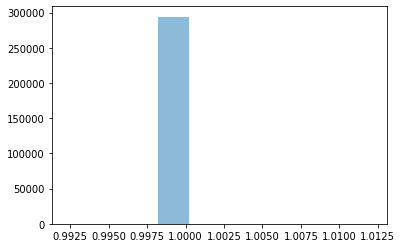

In [ ]:
plt.hist(np.exp(pred).flatten(), alpha = 0.5, label = "test prediction")

In [ ]:
np.exp(pred)

array([[0.99980659, 0.99980659, 0.99980659, ..., 0.99980659, 0.99980659,
        0.99980659],
       [0.99980659, 0.99980659, 0.99980659, ..., 0.99980659, 0.99980659,
        0.99980659],
       [0.99980634, 0.9998066 , 0.9998066 , ..., 0.99980512, 0.99980875,
        0.99980689],
       ...,
       [0.99980656, 0.99980659, 0.99980659, ..., 0.99980659, 0.99980666,
        0.99980659],
       [0.99980657, 0.99980659, 0.99980659, ..., 0.99980658, 0.99980665,
        0.99980659],
       [0.99980659, 0.99980659, 0.99980659, ..., 0.99980659, 0.99980659,
        0.99980659]])

In [ ]:
np.exp(pred).min()

0.9365675660995203

In [ ]:
np.exp(pred).max()

1.0783314444061725

In [ ]:
#explore this for graph auto encoder
#https://github.com/tkipf/gae